# ASF-processed RTC dataset inspection

Now that we have a read in and organized the stack of Sentinel-1 RTC images, this notebook will demonstrate preliminary dataset inspection. 

## Learning goals

- Comparing raster images
- using `xr.groupby()` and `FacetGrid`
- simple raster calculations (keep in?)
- anything else?

First, we'll use cell magic to read in the object we prepared in the first notebook:

In [1]:
import os
import xarray as xr
import rioxarray as rio
import geopandas as gpd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask

from pathlib import Path
from intake.source.utils import reverse_format


In [2]:
%store -r 

Unable to restore variable 'vrt_full', ignoring (use %store -d to forget!)
The error was: <class 'KeyError'>


In [3]:
vrt_full

NameError: name 'vrt_full' is not defined

## Layover-shadow mask

Each RTC image comes with a geotiff file containing a layover-shadow mask. This can help to understand missing data you might see in the imagery files. The layover shadow masks are coded to represent a number of different types of pixels:

The following information is copied from the README file that accompanies each scene: 

```

## 6. Layover-shadow mask

The layover/shadow mask indicates which pixels in the RTC image have been affected by layover and shadow. This layer is tagged with _ls_map.tif

The pixel values are generated by adding the following values together to indicate which layover and shadow effects are impacting each pixel:
0  Pixel not tested for layover or shadow
1  Pixel tested for layover or shadow
2  Pixel has a look angle less than the slope angle
4  Pixel is in an area affected by layover
8  Pixel has a look angle less than the opposite of the slope angle
16 Pixel is in an area affected by shadow

_There are 17 possible different pixel values, indicating the layover, shadow, and slope conditions present added together for any given pixel._

**The values in each cell can range from 0 to 31:**
0  Not tested for layover or shadow
1  Not affected by either layover or shadow
3  Look angle < slope angle
5  Affected by layover
7  Affected by layover; look angle < slope angle
9  Look angle < opposite slope angle
11 Look angle < slope and opposite slope angle
13 Affected by layover; look angle < opposite slope angle
15 Affected by layover; look angle < slope and opposite slope angle
17 Affected by shadow
19 Affected by shadow; look angle < slope angle
21 Affected by layover and shadow
23 Affected by layover and shadow; look angle < slope angle
25 Affected by shadow; look angle < opposite slope angle
27 Affected by shadow; look angle < slope and opposite slope angle
29 Affected by shadow and layover; look angle < opposite slope angle
31 Affected by shadow and layover; look angle < slope and opposite slope angle

```

**layover shadow mask interpreation**:

the values are a summation of 17 possible pixel values:

0 - not tested for layover or shadow
1 - not affected by layover or shadow

3 - look angle < slope angle

5 - affected by layover

7 - affected by layover, look angle < slope

9 - look angle < opposite slope angle

11 - look angle < slope and opposite slope angle

13 - affected by layover; look angle < opposite slope angle

15 - affected by layover; look angle < slope and opposite slope angle

17 - affected by shadow

19 - affected by shadow; look angle < slope angle

21 - affected by layover and shadow

23 - 

Let's write a quick function to take a look at a similar breakdown for other time steps more easily:

```{note}
clean up attr labeling in these plots
```

In [4]:
def power_to_db(input_arr):
    return (10*np.log10(np.abs(input_arr)))

In [23]:
vrt_full.isel(acq_date=1).acq_date.dt.date.data

array(datetime.date(2021, 5, 5), dtype=object)

In [44]:
def plot_timestep(input_arr, time_step_int):
    date = input_arr.isel(acq_date = time_step_int).acq_date.dt.date.data
    fig, axs = plt.subplots(ncols=3, figsize=(24,7))

    input_arr.isel(acq_date=time_step_int).ls.plot(ax=axs[0]);
    power_to_db(input_arr.isel(acq_date=time_step_int).vv).plot(ax=axs[1], cmap = plt.cm.Greys_r);
    power_to_db(input_arr.isel(acq_date=time_step_int).vh).plot(ax=axs[2], cmap = plt.cm.Greys_r);

    fig.suptitle(f'Layover-shadow mask (L), VV (C) and VH (R) backscatter {str(asf_clip.isel(acq_date=time_step_int).acq_date.data)[:-19]}')
    axs[0].set_title(f'{date} layover-shadow map')
    axs[1].set_title(f'{date} VV backscatter')
    axs[2].set_title(f'{date} VH backscatter')


                    
    

```{note}
colorbars on VV, VH images should display dB - but this isn't an attr in the vrt_full object because the power_to_db transform happens in the function call - is there a way to pass this unit on to the attr to be plotted automatically or need to specify manualy?
```

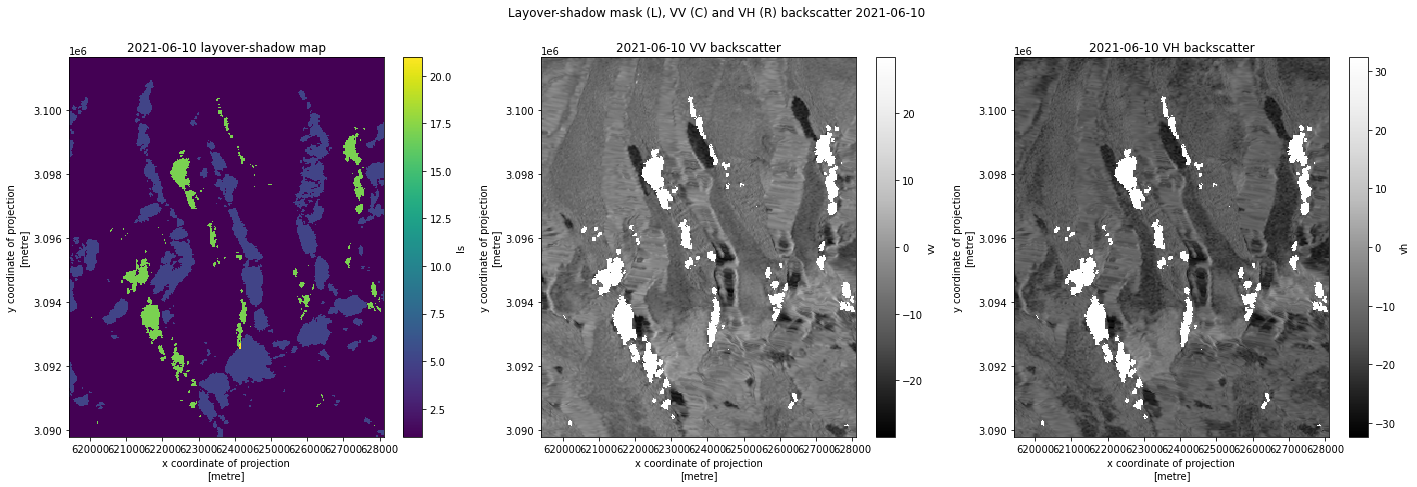

In [45]:
plot_timestep(asf_clip, 11)

In [63]:
cmap1 = plt.cm.get_cmap('Blues', 20)

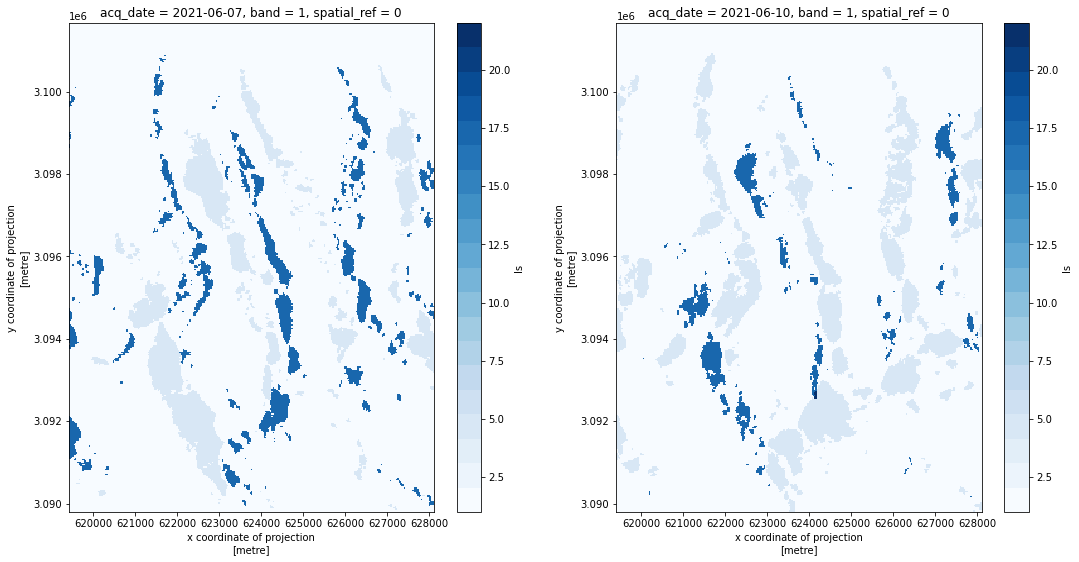

In [64]:
fig, axs = plt.subplots(ncols=2, figsize=(18,9))

asf_clip.isel(acq_date=10).ls.plot(ax=axs[0], vmax = 22, vmin = 1, cmap=cmap1);
asf_clip.isel(acq_date=11).ls.plot(ax=axs[1], vmax = 22, vmin = 1, cmap=cmap1);

It looks like there are areas affected by different distortion effects on different dates. For example, in the lower left quadrant, there is a region that is blue (5) on 6/7/2010 but most of that area appears green (19) on 6/10/2010. On 6/7, that area is affected by layover, but on 6/10 much of that same area seems to be in the radar shadow. This is likely due to different viewing geometries on different orbital passes: one of the above scenes was likely collected during an ascending pass and one during a descending.

Thanks to all the setup work we did in the previous notebook, we can confirm that: 

In [52]:
vrt_full.isel(acq_date=10).orbital_dir.values

array('desc', dtype='<U4')

In [53]:
vrt_full.isel(acq_date=11).orbital_dir.values

array('asc', dtype='<U4')

Let's look at how stable the distortions are over time :

In [5]:
vrt_asc = vrt_full.where(vrt_full.orbital_dir == 'asc', drop=True)
vrt_desc = vrt_full.where(vrt_full.orbital_dir == 'desc', drop=True)

In [6]:
cmap = plt.cm.get_cmap('Purples',15)

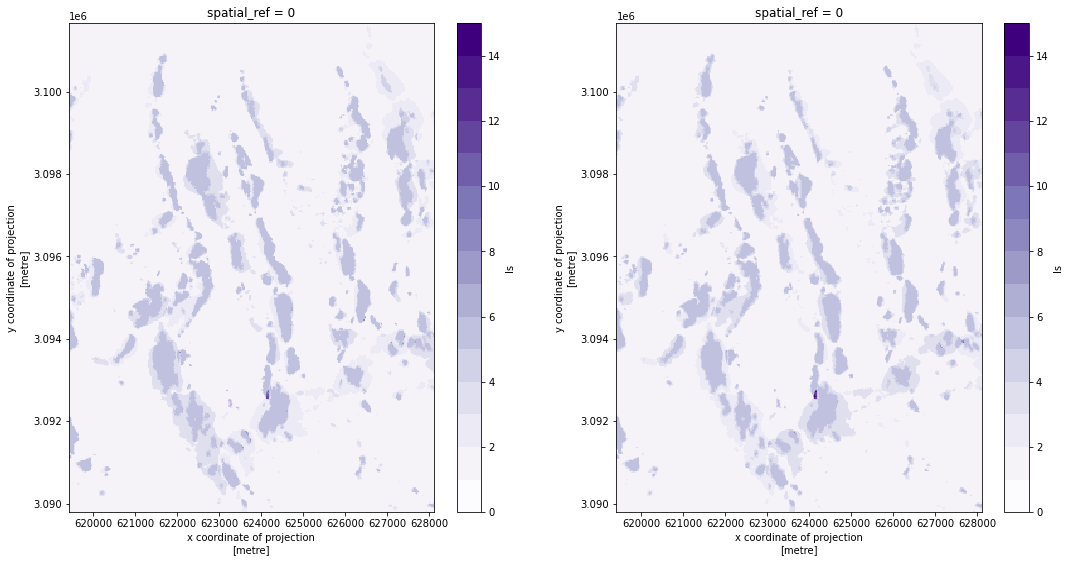

In [62]:
fig, axs = plt.subplots(ncols=2, figsize=(18,9))

vrt_asc.ls.mean(dim='acq_date').plot(ax = axs[0], vmax = 15, vmin = 0, cmap = cmap)
vrt_desc.ls.mean(dim='acq_date').plot(ax=axs[1], vmax=15, vmin = 0, cmap=cmap)

In [6]:
vrt_asc_gb = vrt_asc.groupby(vrt_asc.acq_date.dt.season).mean()

In [7]:
vrt_desc_gb = vrt_desc.groupby(vrt_desc.acq_date.dt.season).mean()

/home/emmamarshall/miniconda3/envs/sentinel/lib/python3.10/site-packages/flox/aggregations.py:258: RuntimeWarning: invalid value encountered in divide
  finalize=lambda sum_, count: sum_ / count,


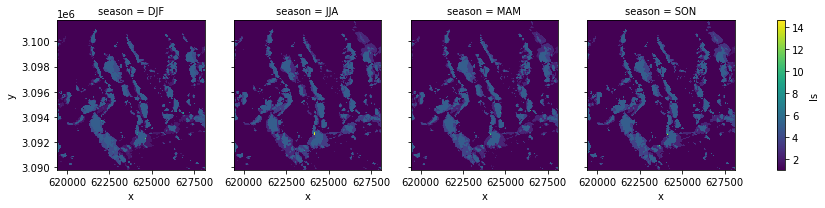

In [9]:
fg_asc = vrt_asc_gb.ls.plot(col='season');

In [8]:
asc_winter_spring = (vrt_asc_gb.sel(season='DJF') - vrt_asc_gb.sel(season='MAM'))
asc_spring_summer = (vrt_asc_gb.sel(season='MAM') - vrt_asc_gb.sel(season='JJA'))

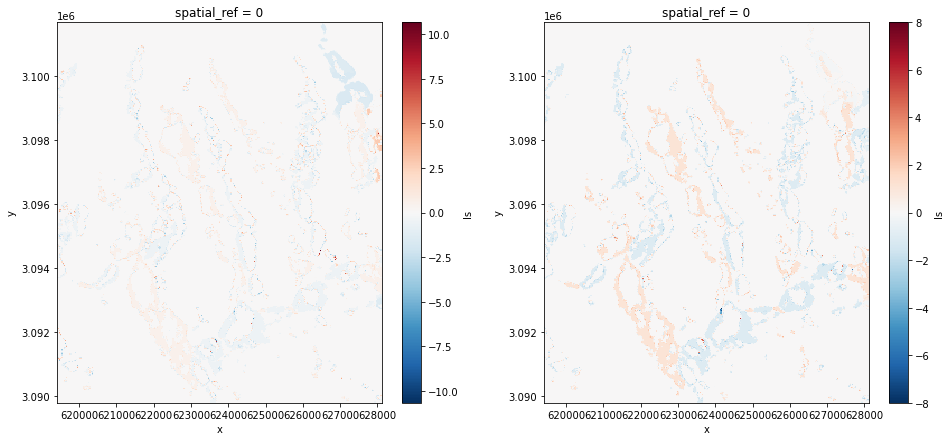

In [9]:
fig, axs = plt.subplots(ncols=2, figsize=(16,7))
asc_winter_spring.ls.plot(ax=axs[0])
asc_spring_summer.ls.plot(ax=axs[1])

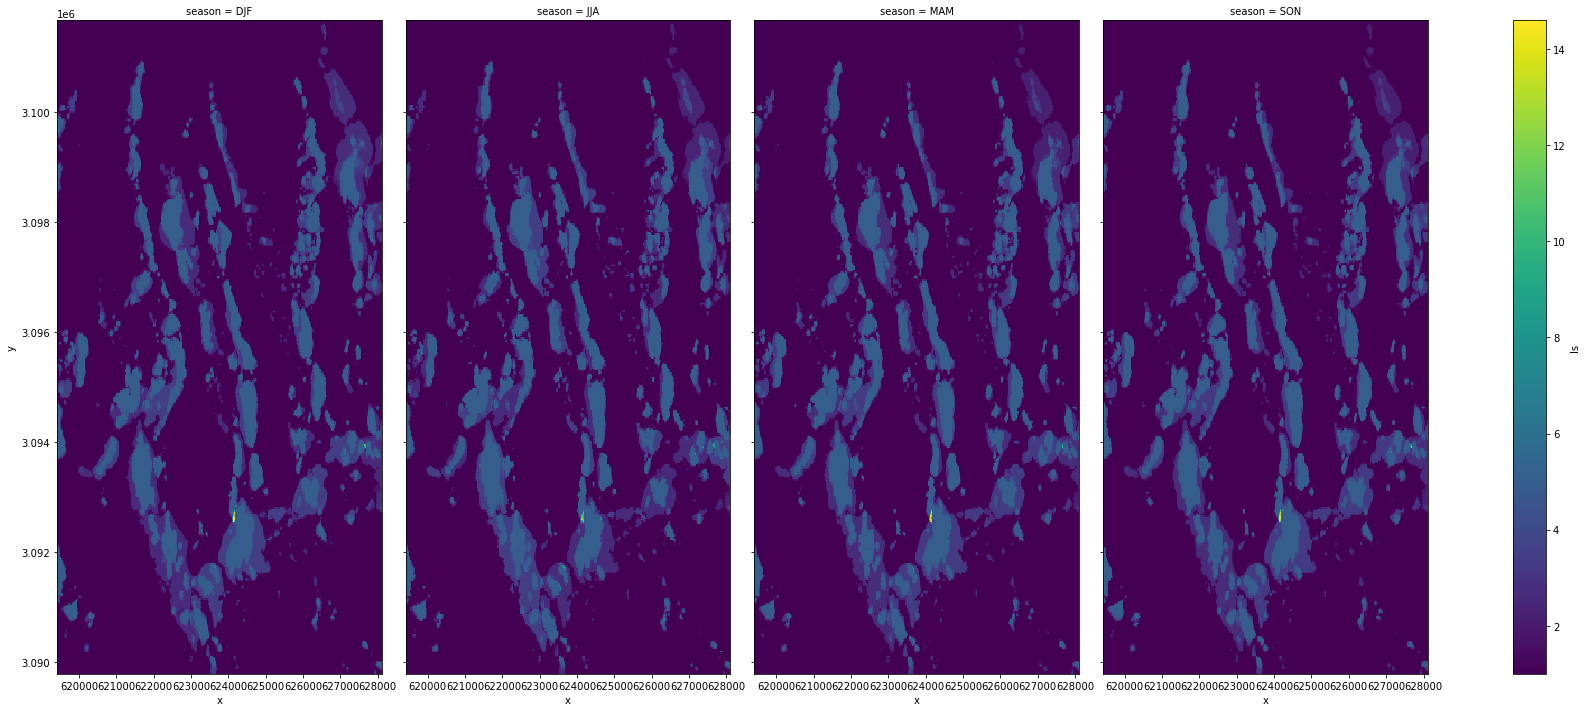

In [10]:
fg_desc = vrt_desc_gb.ls.plot(col='season', figsize=(25,10));

## Handling duplicate time steps

If we take a closer look at the ASF dataset, we can see that there are a few scenes from identical acquisitions (can see this in `acq_date` and more specifically in `product_id`. Let's examine these and see what's going on, if we want to keep the duplicates: 

First we'll extract the data_date_id from the Sentinel-1 granule ID: 

In [21]:
data_take_asf = [str(vrt_full.isel(acq_date = t).granule_id.values)[56:62] for t in range(len(vrt_full.acq_date))]

Then assign it as a non-dimensional coordinate: 

In [22]:
vrt_full.coords['data_take_id'] = ('acq_date', data_take_asf, {'ID of data take from SAR acquisition':'ID data take'})

In [23]:
vrt_full

<xarray.Dataset>
Dimensions:                           (acq_date: 103, y: 396, x: 290)
Coordinates: (12/20)
  * acq_date                          (acq_date) datetime64[ns] 2021-05-02 .....
    granule_id                        (acq_date) <U67 'S1A_IW_SLC__1SDV_20210...
  * x                                 (x) float64 6.194e+05 ... 6.281e+05
  * y                                 (y) float64 3.102e+06 ... 3.09e+06
    spatial_ref                       int64 0
    sensor                            (acq_date) <U3 'S1A' 'S1A' ... 'S1A' 'S1A'
    ...                                ...
    filtered                          (acq_date) <U1 'n' 'n' 'n' ... 'n' 'n' 'n'
    area                              (acq_date) <U1 'e' 'e' 'e' ... 'e' 'e' 'e'
    product_id                        (acq_date) <U4 '748F' '0D1E' ... 'BD36'
    acq_hour                          (acq_date) int64 0 12 12 12 ... 0 12 12 0
    orbital_dir                       (acq_date) <U4 'asc' 'desc' ... 'asc'
    data_take_id                      (acq_date) <U6 '047321' ... '052C00'
Data variables:
    vv                                (acq_date, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    vh                                (acq_date, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    ls                                (acq_date, y, x) float64 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>

In [24]:
asf_ids = list(vrt_full.data_take_id.values)

In [25]:
len(asf_ids)

103

The length of the `asf_ids` list is exactly what we'd expect, 103. Let's look at the length of the `set` object. The `set()` method creates a list of unique elements within a given list. (check thats right and link to resource)

In [26]:
asf_set = set(asf_ids)

In [27]:
len(asf_set)

96

Interesting - it looks like there are only 96 unique elements when we look at the `data_take_id`. Let's figure out which are duplicates:

In [28]:
def duplicate(input_ls):
    return list(set([x for x in input_ls if input_ls.count(x) > 1]))

In [29]:
duplicate_ls = duplicate(asf_ids)
duplicate_ls

['0492D4', '052C00', '05154A', '048D87', '047898']

These are the data take IDs that are duplicated in the dataset. We now want to subset the xarray object to only include these data take IDs: 

In [128]:
asf_duplicate_cond = vrt_full.data_take_id.isin(duplicate_ls)
asf_duplicate_cond

asf_duplicates = vrt_full.where(asf_duplicate_cond == True, drop=True)
asf_duplicates

<xarray.Dataset>
Dimensions:                           (acq_date: 12, y: 396, x: 290)
Coordinates: (12/20)
  * acq_date                          (acq_date) datetime64[ns] 2021-05-14 .....
    granule_id                        (acq_date) <U67 'S1A_IW_SLC__1SDV_20210...
  * x                                 (x) float64 6.194e+05 ... 6.281e+05
  * y                                 (y) float64 3.102e+06 ... 3.09e+06
    spatial_ref                       int64 0
    sensor                            (acq_date) <U3 'S1A' 'S1A' ... 'S1A' 'S1A'
    ...                                ...
    filtered                          (acq_date) <U1 'n' 'n' 'n' ... 'n' 'n' 'n'
    area                              (acq_date) <U1 'e' 'e' 'e' ... 'e' 'e' 'e'
    product_id                        (acq_date) <U4 '61B6' '0535' ... 'BD36'
    acq_hour                          (acq_date) int64 12 12 12 12 ... 12 12 0
    orbital_dir                       (acq_date) <U4 'desc' 'desc' ... 'asc'
    data_take_id                      (acq_date) <U6 '047898' ... '052C00'
Data variables:
    vv                                (acq_date, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    vh                                (acq_date, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    ls                                (acq_date, y, x) float64 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>

Great, now we have a 12-time step xarray object that contains only the duplicate data takes. Let's see what it looks like. We can use `xr.FacetGrid` objects to plot these all at once: 

In [113]:
fg = asf_duplicates.vv.plot(col='acq_date', col_wrap = 4)

ValueError: Coordinates used for faceting cannot contain repeated (nonunique) values.

Oops, we can't use faceting along the `acq_date` dimension here because of the repeated time steps that we want to look at. Xarray does not know how to handle these repeated values when it is creating the small multiples. Let's re-organize this object so that we have a dimension of unique elements along which we can perform faceting. We need to be careful to not lose the data that we are interested in here beacuse the `VV` and `VH` variables exist along the `x`,`y` and `acq_date` dimensions.

To do this, I started by making a copy of the data we want to plot in a FacetGrid object, which is the `VV` band:

In [129]:
asf_vv_arr = asf_duplicates.vv.data

You can check the shape here: 

In [130]:
asf_vv_arr.shape

(12, 396, 290)

This isn't quite what we want - the xarray object has the shape `acq_date, x, y` but this is `acq_date, y, x`. Use the `np.transpose()` method to appropriately re-shape the object:

In [136]:
asf_vv_arr = np.transpose(asf_vv_arr, (0,2,1))

In [137]:
asf_vv_arr.shape

(12, 290, 396)

Now we want to create a new object with expanded dimensions to include a `step` dimension. This will mimic the `acq_date` dimension but have unique values. At the same time we can drop the `acq_date` dimension. We need to do this before we try to facet the object, because we need to pass a 3D not a 4D object to the plotting call.

In [138]:
asf_duplicates_step = asf_duplicates.expand_dims(step = range(12)).drop_dims('acq_date')

In [139]:
asf_duplicates_step

<xarray.Dataset>
Dimensions:      (step: 12, x: 290, y: 396)
Coordinates:
  * step         (step) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * x            (x) float64 6.194e+05 6.195e+05 ... 6.281e+05 6.281e+05
  * y            (y) float64 3.102e+06 3.102e+06 3.102e+06 ... 3.09e+06 3.09e+06
    spatial_ref  int64 0
Data variables:
    *empty*

Next, add the re-shaped data variable to the new object (with a unique name) and specify the appropriate dims:

In [140]:
asf_duplicates_step['vv_1'] = (('step','x','y'), asf_vv_arr)

In [141]:
asf_duplicates_step

<xarray.Dataset>
Dimensions:      (step: 12, x: 290, y: 396)
Coordinates:
  * step         (step) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * x            (x) float64 6.194e+05 6.195e+05 ... 6.281e+05 6.281e+05
  * y            (y) float64 3.102e+06 3.102e+06 3.102e+06 ... 3.09e+06 3.09e+06
    spatial_ref  int64 0
Data variables:
    vv_1         (step, x, y) float32 dask.array<chunksize=(1, 290, 396), meta=np.ndarray>

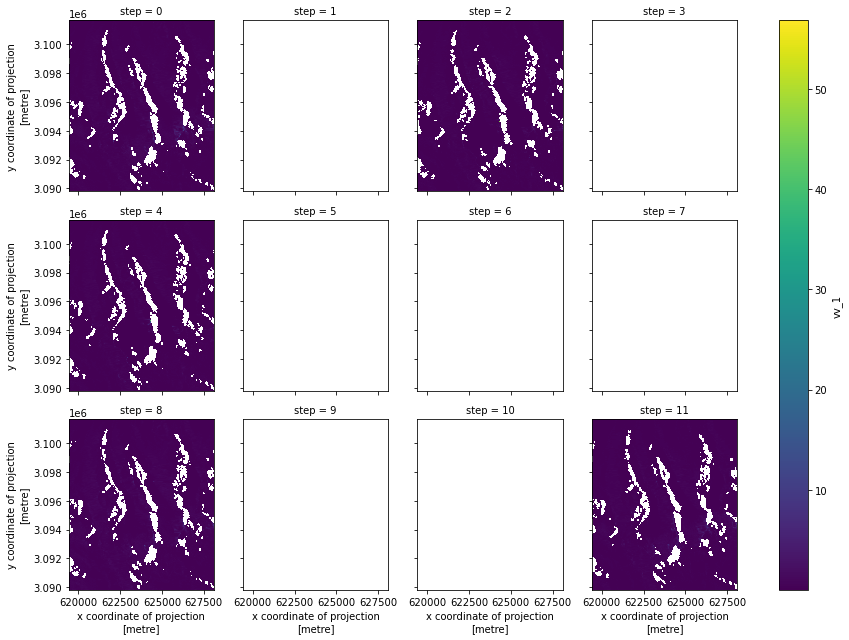

In [142]:
fg = asf_duplicates_step.vv_1.T.plot(col='step', col_wrap = 4)

Interesting, it looks like there's only really data for the 0, 2, 4, 8 and 11 elements of the list of duplicates.

To drop these, we need to extract the product ID of each duplicate we'd like to remove, since this is the only variable that is unique among the duplicates

In [172]:
drop_ls = [1,3,4,5,6,7,9,10]

In [173]:
drop_product_id_ls = [asf_duplicates.isel(acq_date = t).product_id.values for t in range(12) if t in drop_ls]

In [174]:
drop_product_id_ls

[array('0535', dtype='<U4'),
 array('CA1B', dtype='<U4'),
 array('5413', dtype='<U4'),
 array('22BD', dtype='<U4'),
 array('BDC1', dtype='<U4'),
 array('B409', dtype='<U4'),
 array('FA4F', dtype='<U4'),
 array('01F4', dtype='<U4')]

Using this list, we want to drop all of the elements of `vrt_full` where product Id is one of the values in the list.

In [175]:
full_product_id_ls = list(vrt_full.product_id.values)

Drop elements from `full_product_id_ls`:

In [176]:
keep_product_id_ls = [i for i in full_product_id_ls if i not in drop_product_id_ls] 

In [177]:
len(keep_product_id_ls)

95

In [182]:
product_id_condition = vrt_full.product_id.isin(keep_product_id_ls)

vrt_new = vrt_full.where(product_id_condition == True, drop=True)

In [183]:
vrt_new

<xarray.Dataset>
Dimensions:                           (acq_date: 95, y: 396, x: 290)
Coordinates: (12/20)
  * acq_date                          (acq_date) datetime64[ns] 2021-05-02 .....
    granule_id                        (acq_date) <U67 'S1A_IW_SLC__1SDV_20210...
  * x                                 (x) float64 6.194e+05 ... 6.281e+05
  * y                                 (y) float64 3.102e+06 ... 3.09e+06
    spatial_ref                       int64 0
    sensor                            (acq_date) <U3 'S1A' 'S1A' ... 'S1A' 'S1A'
    ...                                ...
    filtered                          (acq_date) <U1 'n' 'n' 'n' ... 'n' 'n' 'n'
    area                              (acq_date) <U1 'e' 'e' 'e' ... 'e' 'e' 'e'
    product_id                        (acq_date) <U4 '748F' '0D1E' ... 'BD36'
    acq_hour                          (acq_date) int64 0 12 12 12 12 ... 0 0 0 0
    orbital_dir                       (acq_date) <U4 'asc' 'desc' ... 'asc'
    data_take_id                      (acq_date) <U6 '047321' ... '052C00'
Data variables:
    vv                                (acq_date, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    vh                                (acq_date, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    ls                                (acq_date, y, x) float64 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>

Now we will store the updated version of `vrt_full` to use in later notebooks:

In [ ]:
%store vrt_new

## Wrap up 

This notebook gives a brief look in to the vast amount of auxiliary data that is contained within this dataset. Making the most and best use of this dataset requires familiarity with the the many different types of information it includes. 